In [2]:
import pandahouse
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

In [4]:
import seaborn as sns

In [ ]:
Задача: проанализировать результаты эксперимента, который проходил с 2022-07-13 по 2022-07-19.
Группа 1 - контрольная (без изменений)
Группа 2 - экспериментальная (новый алгоритм рекомендации постов)

In [5]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [6]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'password',
    'user': 'student',
    'database': 'simulator'
}

In [16]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [17]:
df = pandahouse.read_clickhouse(q, connection=connection)

Проведем обычный t-test и построим гистограммы.

In [19]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

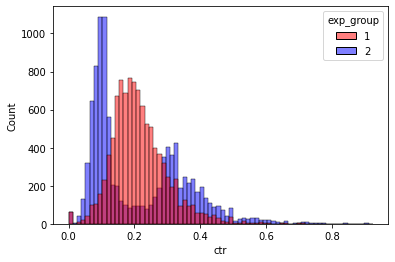

In [20]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

В обычном t-test значимого различия незамечено, но возможно это связано
с ненормальным распределением во второй группе.
Проведем дополнительно тест Манна-Уитни.

In [21]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [ ]:
Теперь p-value показывает статистически значимую разницу между группами.

In [ ]:
До сих пор мы сравнивали поюзерный CTR.
Попробуем пуассоновский бутстреп для сравнения глобальных CTR в псевдовыборках.

In [22]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [23]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

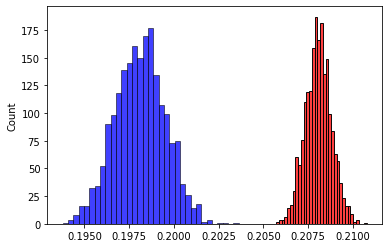

In [28]:
sns.histplot(ctr1, color='r')
sns.histplot(ctr2, color='b')

<AxesSubplot:ylabel='Count'>

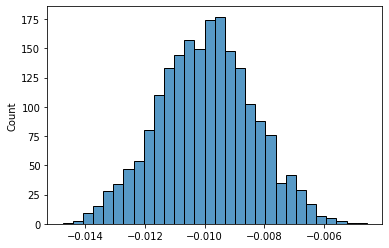

In [25]:
sns.histplot(ctr2 - ctr1)

Отрицательная разница глобальных CTR между 1 и 2 группами показывает ухудшение CTR в экспериментальной группе.

Вывод: раскатывать новый алгоритм на всех пользователей нельзя, так как целевая метрика CTR может в результате ухудшиться. Как вариант, можно посмотреть влияние алгоритма на определенные группы пользователей и создать новые группы для AB-теста, например, по принципу операционной системы.